If the dense displacement fields are not defined on the same spatial grid, we need to first resample one of the dense displacement fields to align with the grid of the other dense displacement field. One way to do this is by using interpolation methods such as bilinear or bicubic interpolation.

In [22]:
import numpy as np
from scipy.interpolate import interpn
from scipy.ndimage import map_coordinates
class RigidTransform:

    # Initialize class
    def __init__(self, rotations, translations, warped_image_size):
        self.rx = rotations[0]
        self.ry = rotations[1]
        self.rz = rotations[2]
        self.tx = translations[0]
        self.ty = translations[1]
        self.tz = translations[2]
        self.warped_image_size_x = warped_image_size[0]
        self.warped_image_size_y = warped_image_size[1]
        self.warped_image_size_z = warped_image_size[2]

        # Precompute rotation matrices around the X, Y, and Z axis
        rot_x = np.array([[1, 0, 0],
                                 [0, np.cos(self.rx), -np.sin(self.rx)],
                                 [0, np.sin(self.rx), np.cos(self.rx)]])
                                 
        rot_y = np.array([[np.cos(self.ry), 0, np.sin(self.ry)],
                                [0, 1, 0],
                                [-np.sin(self.ry), 0, np.cos(self.ry)]])

        rot_z = np.array([[np.cos(self.rz), -np.sin(self.rz), 0],
                                [np.sin(self.rz), np.cos(self.rz), 0],
                                [0, 0, 1]])

        # Compose rotation matrix from yaw, pitch, and roll 
        # Correct order is Z, Y, X
        self.rot_vec = np.matmul(rot_z, np.matmul(rot_y, rot_x))
        #self.rot_vec = rot_z

        # Compose translation vector
        self.trans_vec = np.array([self.tx, self.ty, self.tz])

        # Precompute the dense displacement field DDF
        #self.ddf = self.compute_ddf((self.warped_image_size_x, self.warped_image_size_y, self.warped_image_size_z))
        self.compute_ddf((self.warped_image_size_x, self.warped_image_size_y, self.warped_image_size_z))

    # Implement a class member function compute_ddf that computes displacement vector
    # this code takes a point in the warped image,
    # undo the translation by subtracting the translation vector from the point,
    # then undo the rotation by applying the inverse rotation matrix, 
    # and the result is the displacement vector from the warped image to the original image
    #  at that voxel location.
    def compute_ddf(self, warped_image_size):
        # Compute displacement vector
        self.warped_image_size_x, self.warped_image_size_y, self.warped_image_size_z = warped_image_size
            # Pre-allocate displacement vector
        self.ddf = np.zeros((self.warped_image_size_x, self.warped_image_size_y, self.warped_image_size_z, 3))

        for x in range(self.warped_image_size_x):
            for y in range(self.warped_image_size_y):
                for z in range(self.warped_image_size_z):
                    # Compute displacement vector at each voxel
                    original = np.matmul(np.linalg.inv(self.rot_vec), np.array([x, y, z]) - self.trans_vec)
                    self.ddf[x, y, z] = np.array([x, y, z]) - original
                    #self.ddf[x, y, z, :] = np.matmul(np.linalg.inv(self.rot_vec), np.array([x, y, z]) - self.trans_vec)

# np.natmul(rot_vec, np.array([x, y, z]) +  self.
    # Implement a class member function warp that returns a warped image volume in a Numpy Array
    def warp(self, volume):
        # Pre-allocate warped volume
        warped_image_coords = []
        #warped_volume = np.zeros_like(volume)
        for x in range(volume.shape[0]):
            for y in range(volume.shape[1]):
                for z in range(volume.shape[2]):
                    # Compute new voxel coordinates in the warped image
                    warped_image_coords.append(np.matmul(self.rot_vec, np.array([x, y, z])) + self.trans_vec)
        warped_image_coords = np.array(warped_image_coords)

        # Resample intensity values at the new coordinates
        #warped_volume[x, y, z] = interpn(np.array([x, y, z], ), volume, np.array((new_x, new_y, new_z),), method = 'linear', bounds_error = False, fill_value = None)
        # Resample using scipy.interpolate.griddata
        #warped_volume = griddata(np.array([x, y, z], ), volume, np.array((new_x, new_y, new_z),), method = 'linear', bounds_error = False, fill_value = None)
        warped_volume = map_coordinates(volume, [warped_image_coords.T[0], warped_image_coords.T[1], warped_image_coords.T[2]], order=3, mode='nearest', cval=np.NaN, prefilter=False)
        warped_volume = warped_volume.reshape(volume.shape)
        return warped_volume

    # Implement a class member function compose which represents a combination of two transforms
    def compose(self, rotations2, translations2):

        composed_transform = RigidTransform(rotations2, translations2,  warped_image_size = (128, 128, 32))

        # Update rotation matrix: Check with Ad
        composed_transform.rot_vec = np.matmul(composed_transform.rot_vec, self.rot_vec)

        # Update translation vector: Check with Ad
        composed_transform.trans_vec = np.matmul(composed_transform.rot_vec, self.trans_vec) + np.array(translations2)
        #composed_transform.trans_vec = np.matmul(self.rot_vec, np.array(translations2)) + self.trans_vec

        # Update the displacement field
        composed_transform.compute_ddf((self.warped_image_size_x, self.warped_image_size_y, self.warped_image_size_z))

    

        # # Compute the combined rotation matrix
        # rot_x2 = np.array([[1, 0, 0],
        #                     [0, np.cos(rotations2[0]), -np.sin(rotations2[0])],
        #                     [0, np.sin(rotations2[0]), np.cos(rotations2[0])]])

        # rot_y2 = np.array([[np.cos(rotations2[1]), 0, np.sin(rotations2[1])],
        #                     [0, 1, 0],
        #                     [-np.sin(rotations2[1]), 0, np.cos(rotations2[1])]])

        # rot_z2 = np.array([[np.cos(rotations2[2]), -np.sin(rotations2[2]), 0],
        #                     [np.sin(rotations2[2]), np.cos(rotations2[2]), 0],
        #                     [0, 0, 1]])

        # # Compose rotation matrix from yaw, pitch, and roll 
        # # Correct order is Z, Y, X
        # rot_vec2 = np.matmul(rot_z2, np.matmul(rot_y2, rot_x2))
        # R_composed = np.matmul(self.rot_vec, rot_vec2)

        
        # # Compute the combined translation vector
        # #T_composed = np.matmul(self.rot_vec, np.array(translations2)) + self.trans_vec
        # T_composed = np.matmul(self.rot_vec, self.trans_vec) + np.array(translations2)

        # # Create a new RigidTransform object with the composed transformations
        # composed_transform = RigidTransform(R_composed, T_composed)

        # # Update the displacement field
        # composed_transform.compute_ddf((self.warped_image_size_x, self.warped_image_size_y, self.warped_image_size_z))

        return composed_transform
    
    def compose2(self, rotations2, translations2):

        composed_transform = RigidTransform(rotations2, translations2,  warped_image_size = (128, 128, 32))
        return composed_transform


    # Implement a class member function that to take two ddfs and return the composition of the two ddfs without using the rotation and translation matrices

    # def composing_ddfs(self, ddf1, ddf2, grid):
    #     # Compute the composition of the two ddfs






    # def compose_ddf(self, ddf1, ddf2):
    #     # Compute the composition of the two ddfs
    #     # ddf_composed = np.zeros_like(ddf1)
    #     # for x in range(ddf1.shape[0]):
    #     #     for y in range(ddf1.shape[1]):
    #     #         for z in range(ddf1.shape[2]):
    #     #             ddf_composed[x, y, z, :] = np.matmul(self.rot_vec, ddf1[x, y, z, :]) + ddf2[x, y, z, :]

    #     return ddf_composed
        
        
                    

In [33]:
import numpy as np
def func(x, y):
    return x*(1-x)*np.cos(4*np.pi*x) * np.sin(4*np.pi*y**2)**2

grid_x, grid_y = np.mgrid[0:1:100j, 0:1:200j]

In [34]:
grid_x

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01010101, 0.01010101, 0.01010101, ..., 0.01010101, 0.01010101,
        0.01010101],
       [0.02020202, 0.02020202, 0.02020202, ..., 0.02020202, 0.02020202,
        0.02020202],
       ...,
       [0.97979798, 0.97979798, 0.97979798, ..., 0.97979798, 0.97979798,
        0.97979798],
       [0.98989899, 0.98989899, 0.98989899, ..., 0.98989899, 0.98989899,
        0.98989899],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ]])

In [35]:
grid_y

array([[0.        , 0.00502513, 0.01005025, ..., 0.98994975, 0.99497487,
        1.        ],
       [0.        , 0.00502513, 0.01005025, ..., 0.98994975, 0.99497487,
        1.        ],
       [0.        , 0.00502513, 0.01005025, ..., 0.98994975, 0.99497487,
        1.        ],
       ...,
       [0.        , 0.00502513, 0.01005025, ..., 0.98994975, 0.99497487,
        1.        ],
       [0.        , 0.00502513, 0.01005025, ..., 0.98994975, 0.99497487,
        1.        ],
       [0.        , 0.00502513, 0.01005025, ..., 0.98994975, 0.99497487,
        1.        ]])

In [36]:
rng = np.random.default_rng()
points = rng.random((1000, 2))
values = func(points[:,0], points[:,1])

In [37]:
points.shape

(1000, 2)

In [38]:
points.values

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [24]:
# Load image train 00
volume = np.load('image_train00.npy').T
orig_coords = np.stack(np.mgrid[:volume.shape[0], :volume.shape[1], :volume.shape[2]], axis = -1)
# Define translation and rotation parameters
rotations = np.deg2rad(np.array([0, 0, 0]))
translations = np.array([5, 0, 0])

rotations2 = np.deg2rad([3, 3, 3])
translations2 = np.array([0, 0, 0])
rigid_transform = RigidTransform(rotations = rotations, translations = translations, warped_image_size = (128, 128, 32))

# Extract ddf
ddf1 = rigid_transform.ddf
grid1 = orig_coords + np.array(ddf1)


In [26]:
rigid_transform = RigidTransform(rotations = rotations, translations = translations, warped_image_size = (128, 128, 32))

In [6]:
ddf1

array([[[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00, -8.71557427e-02,  3.80530191e-03],
         [ 0.00000000e+00, -1.74311485e-01,  7.61060382e-03],
         ...,
         [ 0.00000000e+00, -2.52751654e+00,  1.10353755e-01],
         [ 0.00000000e+00, -2.61467228e+00,  1.14159057e-01],
         [ 0.00000000e+00, -2.70182803e+00,  1.17964359e-01]],

        [[ 0.00000000e+00,  3.80530191e-03,  8.71557427e-02],
         [ 0.00000000e+00, -8.33504408e-02,  9.09610447e-02],
         [ 0.00000000e+00, -1.70506184e-01,  9.47663466e-02],
         ...,
         [ 0.00000000e+00, -2.52371124e+00,  1.97509498e-01],
         [ 0.00000000e+00, -2.61086698e+00,  2.01314800e-01],
         [ 0.00000000e+00, -2.69802272e+00,  2.05120102e-01]],

        [[ 0.00000000e+00,  7.61060382e-03,  1.74311485e-01],
         [ 0.00000000e+00, -7.95451389e-02,  1.78116787e-01],
         [ 0.00000000e+00, -1.66700882e-01,  1.81922089e-01],
         ...,
         [ 0.00000000e+0

In [12]:
warped_volume = rigid_transform.warp(volume)

In [13]:
warped_volume.shape

(128, 128, 32)

Text(0.5, 1.0, 'Warped')

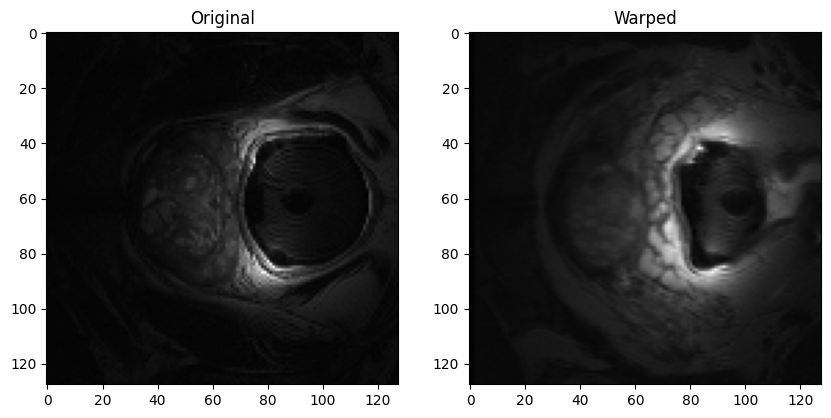

In [30]:
import matplotlib.pyplot as plt
# Visualize example slices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(volume[:,:,15], cmap='gray')
ax1.set_title('Original')
ax2.imshow(warped_volume[:,:,15], cmap='gray')
ax2.set_title('Warped')

In [31]:
warped_volume

array([[[ 54,   0,   0, ...,   0,   0,   0],
        [ 47,  65,  64, ...,   0,   0,   0],
        [ 79,  78,  74, ...,   0,   0,   0],
        ...,
        [ 81,  77,  88, ...,   0,   0,   0],
        [ 65,  92,  74, ...,   0,   0,   0],
        [ 64,  80,  55, ...,   0,   0,   0]],

       [[ 53,   0,   0, ...,   0,   0,   0],
        [ 99,  67,  77, ...,   0,   0,   0],
        [ 68,  67,  83, ...,   0,   0,   0],
        ...,
        [ 71,  98,  76, ...,   0,   0,   0],
        [ 73,  94,  84, ...,   0,   0,   0],
        [ 67,  72,  93, ...,   0,   0,   0]],

       [[ 97,   0,   0, ...,   0,   0,   0],
        [ 47,  88,  76, ...,   0,   0,   0],
        [ 66,  84,  59, ...,   0,   0,   0],
        ...,
        [ 74,  66,  82, ...,   0,   0,   0],
        [ 82,  69,  97, ...,   0,   0,   0],
        [ 78,  74,  97, ...,   0,   0,   0]],

       ...,

       [[ 85,   0,   0, ...,   0,   0,   0],
        [ 50,  66,  88, ...,   0,   0,   0],
        [114, 134, 182, ...,   0,   0,   0

In [17]:
warped_volume.shape

(128, 128, 32)

In [ ]:

composed_transform = rigid_transform.compose2(rotations2, translations2)
# Extract ddf
ddf2 = composed_transform.ddf
grid2 = orig_coords + np.array(ddf2)

If the dense displacement fields are not defined on the same spatial grid, we need to first resample one of the dense displacement fields to align with the grid of the other dense displacement field. One way to do this is by using interpolation methods such as bilinear or bicubic interpolation.

In [48]:
grid1.shape

(128, 128, 32, 3)

In [6]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator

# Define a function to compute the displacement field
def composing_ddfs(ddf1, ddf2, grid1, grid2, method = 'linear'):
    # If the dense displacement fields are not defined on the same spatial grid,
    # we need to first resample one of the dense displacement fields to align with
    # the grid of the other dense displacement field.
    if grid1 != grid2:
        #Create interpolating function for the second dense displacement field
        ddf2_interp = RegularGridInterpolator(grid2, ddf2, method = method, bounds_error = False, fill_value = None)

        # Resample the second dense displacement field to the grid of the first dense displacement field
        points = np.array(np.meshgrid(*grid1, indexing = 'ij')).reshape(len(grid1), -1).T
        ddf2_on_grid1 = ddf2_interp(points).reshape(ddf1.shape)

    else:
        ddf2_on_grid1 = ddf2
    
    return ddf1 + ddf2_on_grid1





(128, 128, 32, 3)

In [53]:
np.array(np.meshgrid(*volume.shape, indexing = 'ij'))

array([[[[128]]],


       [[[128]]],


       [[[ 32]]]])

In [50]:
volume

array([[[ 54,  65,  92, ...,  55,  94,  70],
        [ 45,  66,  57, ...,  68,  64,  60],
        [ 79,  80,  74, ...,  85,  74,  75],
        ...,
        [ 53,  68,  65, ...,  53,  64,  61],
        [111,  76,  66, ...,  74,  84,  83],
        [ 75,  74,  58, ...,  49,  84,  49]],

       [[ 53,  66,  31, ...,  88,  90,  92],
        [102,  66,  87, ...,  80,  92, 106],
        [ 68,  64,  81, ...,  77,  89,  74],
        ...,
        [ 96,  85,  81, ...,  91,  68,  80],
        [ 71,  98,  89, ...,  76,  80,  98],
        [120,  75,  81, ...,  80,  54,  62]],

       [[ 97,  86,  83, ...,  99,  95,  82],
        [ 43,  89,  75, ..., 102,  96,  99],
        [ 61,  91,  51, ...,  58,  97,  89],
        ...,
        [109,  75,  86, ...,  69,  64,  65],
        [ 74,  75,  67, ...,  71,  80,  63],
        [141,  81,  57, ...,  86, 103, 102]],

       ...,

       [[ 85,  60,  59, ..., 153, 171,  98],
        [ 49,  64,  95, ..., 147, 151, 123],
        [112, 129, 195, ..., 143, 147,  78

In [63]:
interpn((grid1[0][0][:, 0], grid1[0][0][:, 1], grid1[0][0][:, 2]),
         ddf1, 
         grid2, 
         method = 'linear', 
         bounds_error = False,
         fill_value = None)


ValueError: There are 32 points and 128 values in dimension 0

In [64]:
grid2.shape

(128, 128, 32, 3)

In [67]:
grid1[0][0][:, 2].shape

(32,)

In [62]:
grid1

array([[[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-8.71557427e-02,  8.68240888e-02,  1.99240388e+00],
         [-1.74311485e-01,  1.73648178e-01,  3.98480775e+00],
         ...,
         [-2.52751654e+00,  2.51789858e+00,  5.77797124e+01],
         [-2.61467228e+00,  2.60472267e+00,  5.97721163e+01],
         [-2.70182803e+00,  2.69154675e+00,  6.17645202e+01]],

        [[ 8.68240888e-02,  1.99306592e+00, -7.92568709e-02],
         [-3.31653914e-04,  2.07989001e+00,  1.91314701e+00],
         [-8.74873967e-02,  2.16671410e+00,  3.90555088e+00],
         ...,
         [-2.44069245e+00,  4.51096450e+00,  5.77004555e+01],
         [-2.52784819e+00,  4.59778859e+00,  5.96928594e+01],
         [-2.61500394e+00,  4.68461268e+00,  6.16852633e+01]],

        [[ 1.73648178e-01,  3.98613184e+00, -1.58513742e-01],
         [ 8.64924349e-02,  4.07295593e+00,  1.83389013e+00],
         [-6.63307828e-04,  4.15978002e+00,  3.82629401e+00],
         ...,
         [-2.35386836e+0

In [18]:
grid2.shape

(128, 128, 32, 3)

In [17]:
ddf2.shape

(128, 128, 32, 3)

In [ ]:
128*128*32

In [20]:
x = np.linspace(1,4,11)
y = np.linspace(4,7,22)
z = np.linspace(7,9,33)
V = np.zeros((11,22,33))
for i in range(11):
    for j in range(22):
        for k in range(33):
            V[i,j,k] = 100*x[i] + 10*y[j] + z[k]

In [24]:
V.shape

(11, 22, 33)

In [47]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator
print(grid2.shape)
print(ddf2.shape)
ddf2_interp = RegularGridInterpolator(grid2, ddf2, method = 'linear',
bounds_error = False, fill_value = None)

(128, 128, 32, 3)
(128, 128, 32, 3)


ValueError: There are 128 point arrays, but values has 4 dimensions

In [46]:
grid2.T.shape

(3, 32, 128, 128)

In [37]:
grid2.shape

(128, 128, 32, 3)

In [27]:
ddf2tr.shape

(128, 128, 96)

In [28]:
grid2.shape

(128, 128, 32, 3)

In [31]:
ddf2.shape

(128, 128, 32, 3)

In [10]:
ddf2tr=np.reshape(ddf2, (grid2.shape[0], grid2.shape[1], -1))

In [13]:
x = np.linspace(0, 1, 3) #  or  0.5*np.arange(3.) works too
print(x)
# populate the 3D array of values (re-using x because lazy)
X, Y, Z = np.meshgrid(x, x, x, indexing='ij')
vals = np.sin(X) + np.cos(Y) + np.tan(Z)
vals.shape

[0.  0.5 1. ]


(3, 3, 3)

In [14]:
X

array([[[0. , 0. , 0. ],
        [0. , 0. , 0. ],
        [0. , 0. , 0. ]],

       [[0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5]],

       [[1. , 1. , 1. ],
        [1. , 1. , 1. ],
        [1. , 1. , 1. ]]])

In [3]:
np.array([5, 5, 5])*np.pi/180

array([0.08726646, 0.08726646, 0.08726646])

In [ ]:
# Create an affine matrix 4by4
rx, ry, rz = np.array([45, 45, 45])*np.pi/180
tx, ty, tz = np.array([0, 0, 0])
rot_x = np.array([[1, 0, 0, 0],
                        [0, np.cos(rx), -np.sin(rx), 0],
                        [0, np.sin(rx), np.cos(rx), 0],
                        [0, 0, 0, 1]])
                        
rot_y = np.array([[np.cos(ry), 0, np.sin(ry), 0],
                        [0, 1, 0, 0],
                        [-np.sin(ry), 0, np.cos(ry), 0],
                        [0, 0, 0, 1]])

rot_z = np.array([[np.cos(rz), -np.sin(rz), 0, 0],
                        [np.sin(rz), np.cos(rz), 0, 0],
                        [0, 0, 1, 0],
                        [0, 0, 0, 1]])

# 3D translation matrix
trans_vec = np.array([[1, 0, 0, tx],
                        [0, 1, 0, ty],
                        [0, 0, 1, tz],
                        [0, 0, 0, 1]])

rot_vec = np.matmul(rot_z, np.matmul(rot_y, rot_x))

# Transf matrix
tf_mat = np.matmul(trans_vec, rot_vec)
tf_mat

In [ ]:
np.mat(tf_mat)

In [31]:
# Create deformation matrix that represents how each voxel in the image is displaced
X, Y, Z = np.mgrid[:volume.shape[0], :volume.shape[1], :volume.shape[2]]

In [ ]:
num_pix_x, num_pix_y, num_pix_z = volume.shape
total_pix = num_pix_x * num_pix_y * num_pix_z
pix_coords = np.array([np.reshape(X, -1), np.reshape(Y, -1), np.reshape(Z, -1), np.ones(total_pix)])
pix_coords

In [ ]:
# form 2D matrices containing all the pixel coordinates
num_pix_x, num_pix_y = (10, 10)
[X,Y] = np.mgrid[0:num_pix_x, 0:num_pix_y]
X

In [8]:
total_pix = num_pix_x * num_pix_y
total_pix

100

In [ ]:

# reshape and combine coordinate matrices into a 3 x N matrix, where N is
# the total number of pixels (num_pix_x x num_pix_y)
# the 1st row contains the x coordinates, the 2nd the y coordinates, and the
# 3rd row is all set to 1 (i.e. using homogenous coordinates)
total_pix = num_pix_x * num_pix_y
pix_coords = np.array([np.reshape(X, -1), np.reshape(Y, -1), np.ones(total_pix)])
pix_coords

In [ ]:
trans_coords = (tf_mat) @ pix_coords
trans_coords

In [43]:
def_field = np.zeros((num_pix_x, num_pix_y, num_pix_z))
def_field.shape

(128, 128, 32)

In [ ]:

def_field[:,:,0] = np.reshape(trans_coords[0,:], (num_pix_x, num_pix_y, num_pix_z))

In [ ]:

def_field[:,:,0] = np.reshape(trans_coords[0,:], (num_pix_x, num_pix_y, num_pix_z))
def_field[:,:,1] = np.reshape(trans_coords[1,:], (num_pix_x, num_pix_y, num_pix_z))
def_field[:,:,2] = np.reshape(trans_coords[2,:], (num_pix_x, num_pix_y, num_pix_z))

In [ ]:
np.reshape(trans_coords[2,:], (num_pix_x, num_pix_y, num_pix_z))

In [ ]:
points = (np.array((128, 128)) - 1)/2
angle = 5
angle = np.deg2rad(angle)
# First apply translation to the centre of the image
T1 = np.matrix([[1, 0, -points[0]], [0, 1, -points[1]], [0,0,1]])
# Then apply rotation
#R = affineMatrixForRotationAboutPoint(angle, points)
R = np.matrix([[np.cos(angle), -np.sin(angle), 0],[np.sin(angle), np.cos(angle), 0], [0,0,1]])
# Then apply translation back to the original centre of the image
T2 = np.matrix([[1, 0, points[0]], [0, 1, points[1]], [0,0,1]])

# Combine the three affine matrices into one
T = T2*R*T1
T

In [ ]:
trans_coords = T * pix_coords
trans_coords

In [12]:
trans_coords.shape

(3, 100)

In [5]:
rigid_transform.ddf.shape

(128, 128, 32, 3)

In [ ]:
rigid_

In [7]:
xt=rigid_transform.compute_ddf((128, 128, 32))

In [ ]:
xt

In [15]:
rigid_transform.rot_vec

array([[ 0.5       , -0.14644661,  0.85355339],
       [ 0.5       ,  0.85355339, -0.14644661],
       [-0.70710678,  0.5       ,  0.5       ]])

In [7]:
warped_volume = rigid_transform.warp(volume)
#warped_volume.dtype = np.float32

In [17]:
print(warped_volume.shape)
print(volume.shape)

(128, 128, 32)
(128, 128, 32)


In [18]:
xx = np.arange(10, dtype = np.float32)
xx[xx == 0] = np.NaN

In [15]:
xx.dtype

dtype('int64')

In [13]:
warped_volume.dtype

dtype('int16')

In [ ]:
# # Replace zeos with nans
# warped_volume[warped_volume == 0] = np.NaN
# warped_volume


Text(0.5, 1.0, 'Warped')

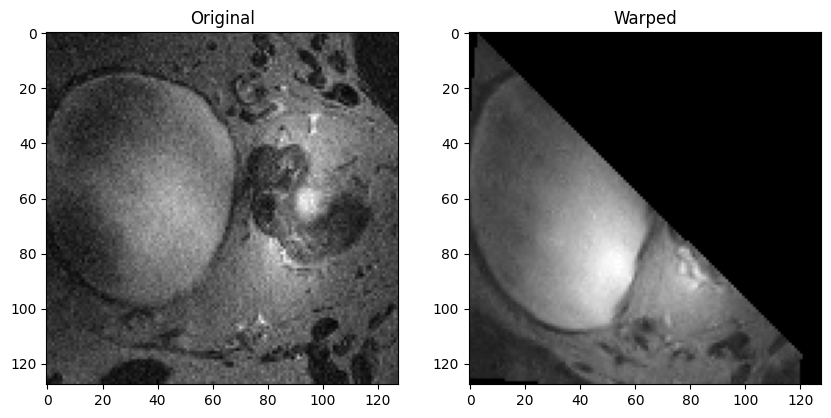

In [8]:
import matplotlib.pyplot as plt
# Visualize example slices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(volume[:,:,31], cmap='gray')
ax1.set_title('Original')
ax2.imshow(warped_volume[:,:,31], cmap='gray')
ax2.set_title('Warped')

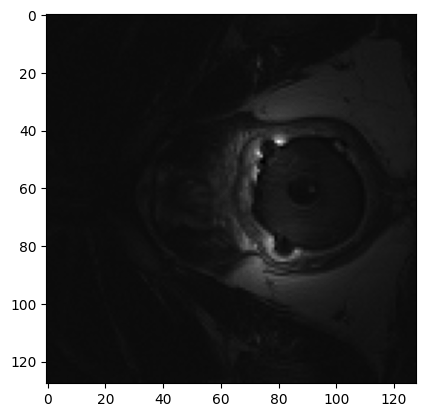

In [9]:
plt.imshow(volume[:,:,9], cmap='gray')

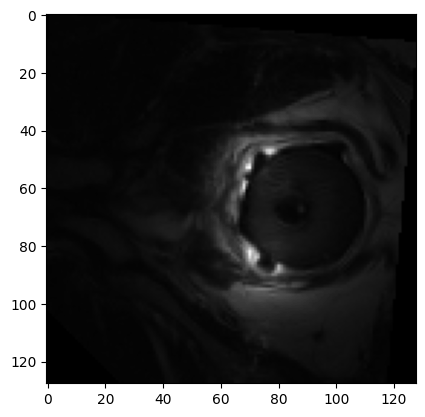

In [11]:
plt.imshow(warped_volume[:,:,9], cmap='gray')

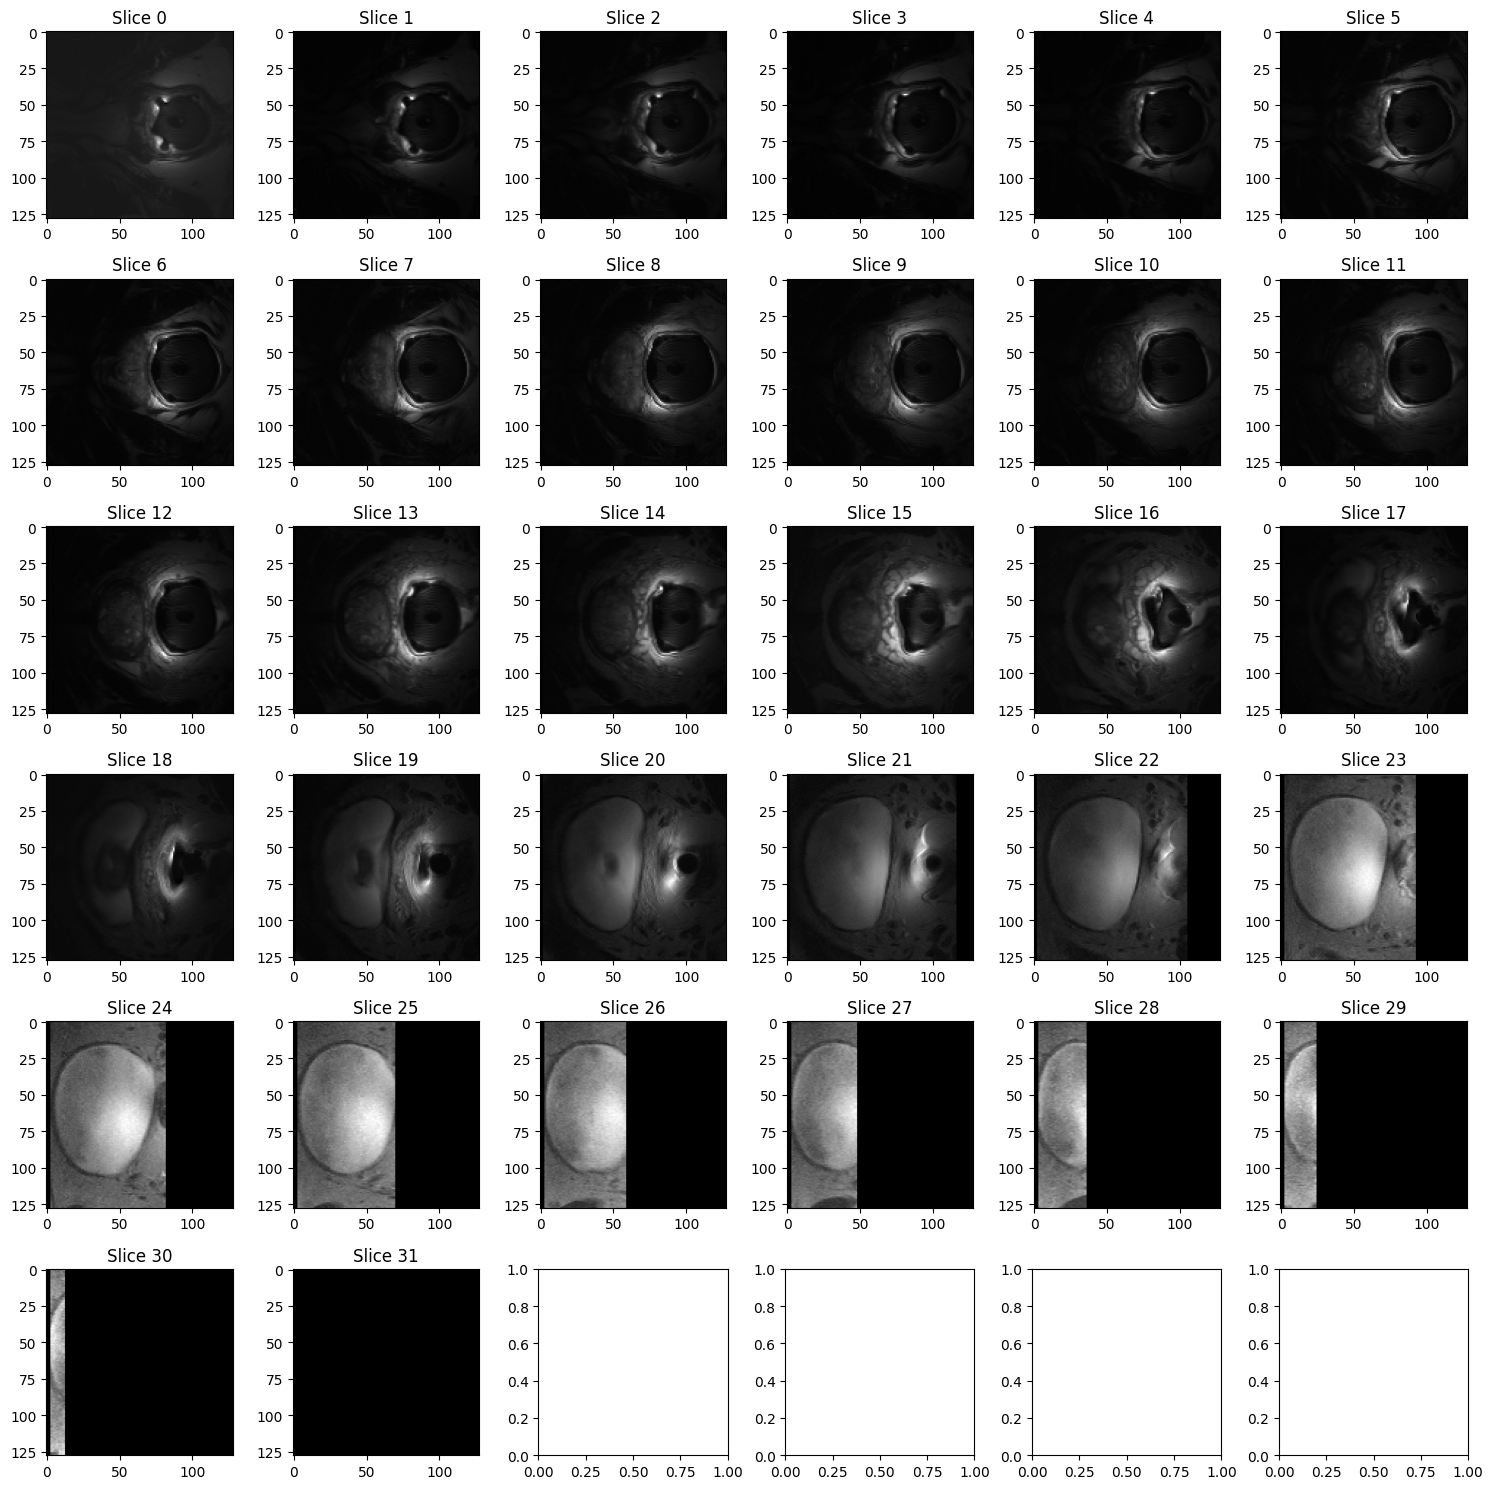

In [29]:

# Visualize slices
n_rows = 6
n_cols = 6

# Create a figure with a subplot grid
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 15))

# Iterate over the slices of the image
for row in range(n_rows):
    for col in range(n_cols):
        slice_idx = row * n_cols + col
        if slice_idx >= warped_volume.shape[2]:
            break
        slice_data = warped_volume[:, :, slice_idx]
        axs[row, col].imshow(slice_data, cmap='gray')
        # Add title to each subplot
        axs[row, col].set_title(f'Slice {slice_idx}')

# Adjust the layout and show the figure
plt.tight_layout()
plt.show()

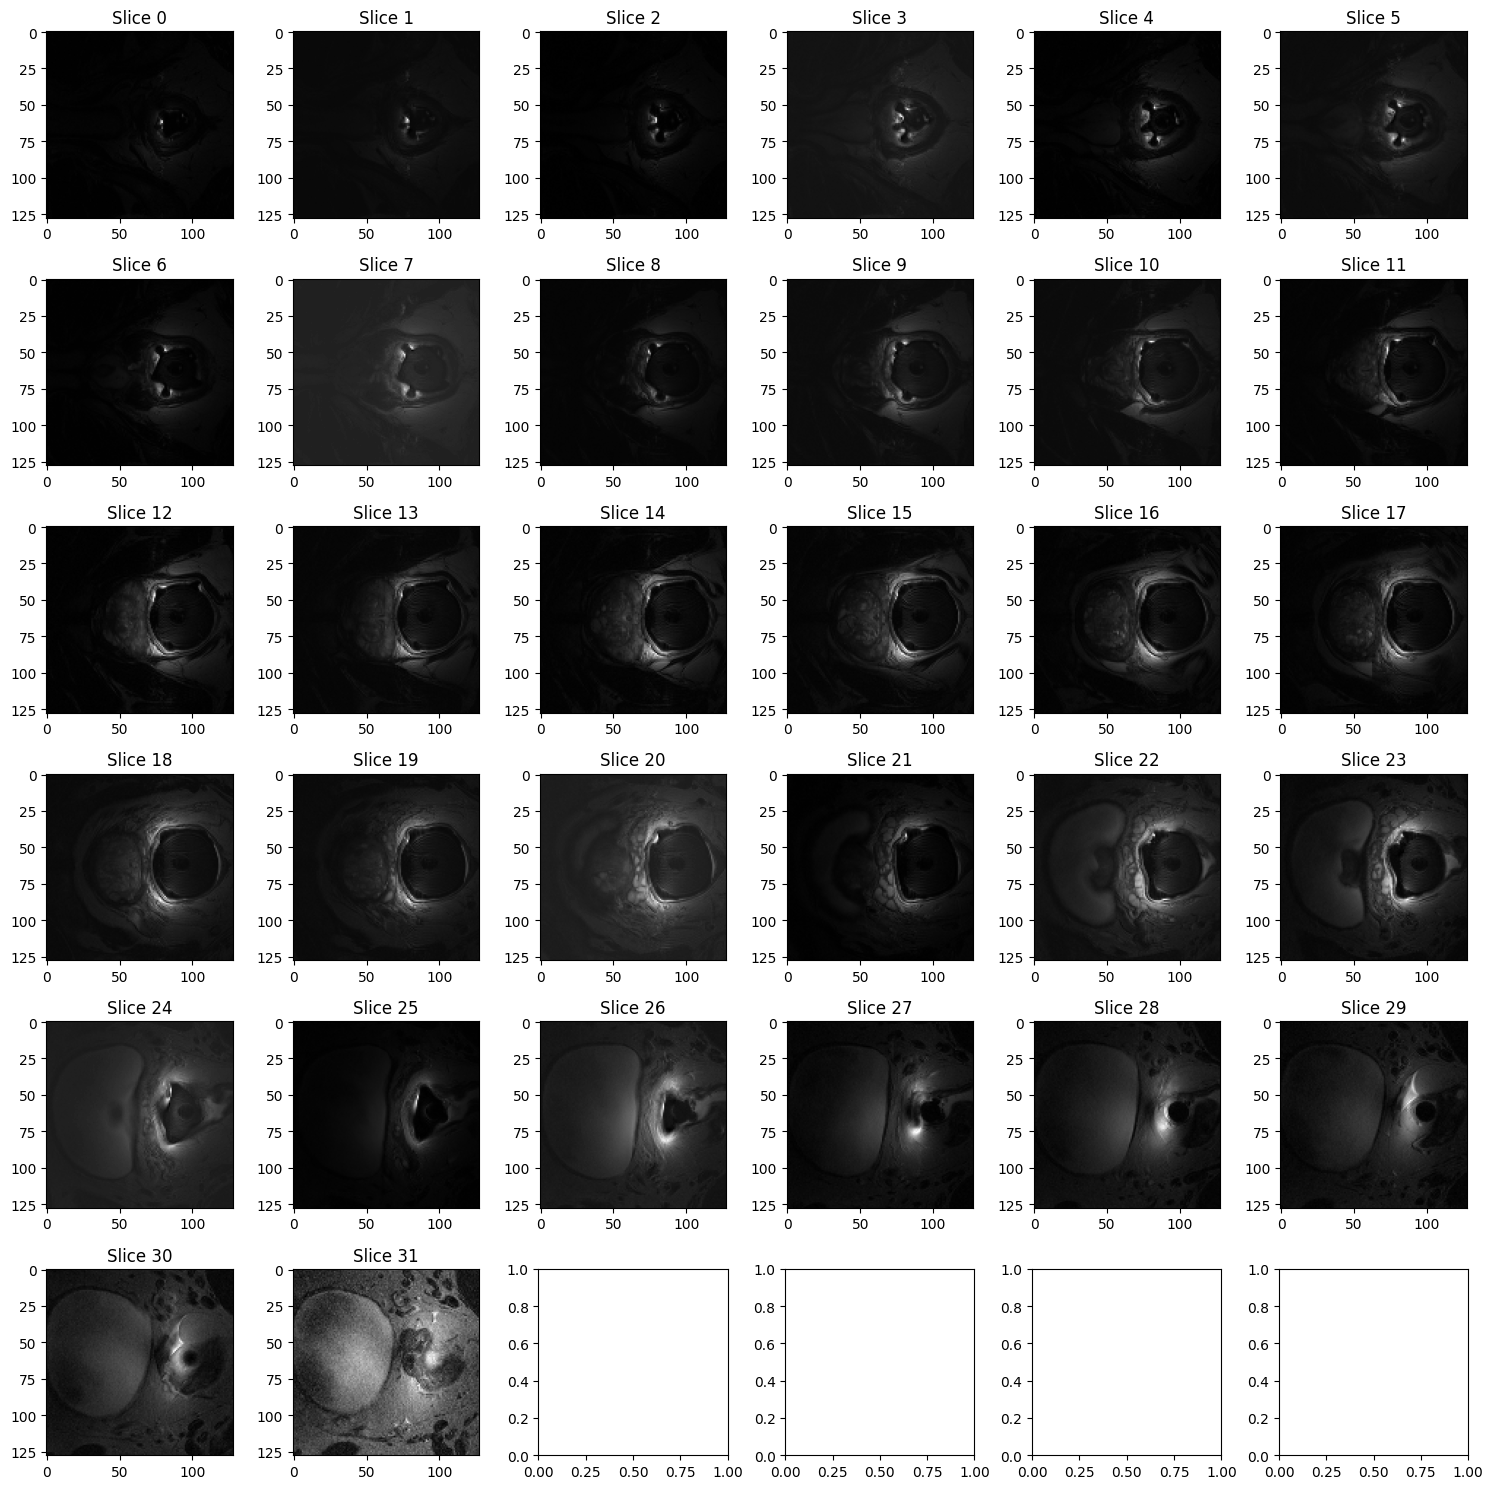

In [54]:

# Visualize slices
n_rows = 6
n_cols = 6

# Create a figure with a subplot grid
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 15))

# Iterate over the slices of the image
for row in range(n_rows):
    for col in range(n_cols):
        slice_idx = row * n_cols + col
        if slice_idx >= volume.shape[2]:
            break
        slice_data = volume[:, :, slice_idx]
        axs[row, col].imshow(slice_data, cmap='gray')
        # Add title to each subplot
        axs[row, col].set_title(f'Slice {slice_idx}')

# Adjust the layout and show the figure
plt.tight_layout()
plt.show()

In [ ]:
# Implement a class RigidTransform which should specify a 3Drigid transformation
# which can warp 3D image volumes.
import numpy as np
from scipy.interpolate import interpn
from scipy.ndimage import map_coordinates
from scipy.interpolate import griddata

class RigidTransform:

    """
    This class implements a 3D rigid transformation which can compute the displacement vector field,
    warp an image volume and combine two rigid transformations. The class is initialized with a rotation vector and a translation vector.

    compute_ddf: computes the displacement vector field from the warped image to the original image
    warp: warps an image volume
    compose: combines two rigid transformations

    """



    # Initialize class with rotations and translations
    def __init__(self, rotations, translations, image_size, flag_composing_ddf = False):
        self.rx = rotations[0]
        self.ry = rotations[1]
        self.rz = rotations[2]
        self.tx = translations[0]
        self.ty = translations[1]
        self.tz = translations[2]
        self.flag_composing_ddf = flag_composing_ddf
       

        # Precompute a rotation matrix and a translation vector stored in the class object
        # Precompute rotation matrices around the X, Y, and Z axis
        rot_x = np.array([[1, 0, 0],
                                 [0, np.cos(self.rx), -np.sin(self.rx)],
                                 [0, np.sin(self.rx), np.cos(self.rx)]])
                                 
        rot_y = np.array([[np.cos(self.ry), 0, np.sin(self.ry)],
                                [0, 1, 0],
                                [-np.sin(self.ry), 0, np.cos(self.ry)]])

        rot_z = np.array([[np.cos(self.rz), -np.sin(self.rz), 0],
                                [np.sin(self.rz), np.cos(self.rz), 0],
                                [0, 0, 1]])

        # Compose rotation matrix by multiplying matrices in the correct order
        # Correct order is Z, Y, X
        self.rot_vec = np.matmul(rot_z, np.matmul(rot_y, rot_x))

        # Compose translation vector
        self.trans_vec = np.array([self.tx, self.ty, self.tz])

        # Compute displacement vector field
        self.compute_ddf(image_size)
    
    # Implement a class function compute_ddf which returns a 3D displacement vector
    # from warped image to original image at each warped image voxel location
    def compute_ddf(self, warped_image_size):
        # Docstring describing the image coordinate system used in this function
        """
        The image coordinate system is a Cartesian coordinate system defined as follows:
        The origin of the coordinate system is at the top left corner of the image.
        The x-axis points to the right, the y-axis points down, and the z-axis points into the image.
        The unit used is voxel, with the distance between two adjacent voxels being 1 in all three dimensions (x, y, z).
        This coordinate system is consistent for both the warped image and the original image,
        meaning that the coordinates of the voxels in both images are defined in the same way.

        This code takes a point in the warped image, and computes the corresponding point in the original image.
        The displacement vector is the difference between the original image point and the warped image point.

        """



        # Save warped image sizes in the class object
        self.warped_image_size_x, self.warped_image_size_y, self.warped_image_size_z = warped_image_size

        # Pre-allocate displacement vector
        self.ddf = np.zeros((self.warped_image_size_x, self.warped_image_size_y, self.warped_image_size_z, 3))

        # Loop through all points in the warped image to
        # undo the translation by subtracting the translation vector from the point,
        # then undo the rotation by applying the inverse rotation matrix
        # the result is the point in the original image
        for x in range(self.warped_image_size_x):
            for y in range(self.warped_image_size_y):
                for z in range(self.warped_image_size_z):
                    # Original image point
                    original_coords = np.matmul(np.linalg.inv(self.rot_vec), np.array([x, y, z]) - self.trans_vec)
                    # Displacement vector
                    self.ddf[x, y, z, :] = np.array([x, y, z]) - original_coords
    

    # Implement a class member function warp which takes an image volume and returns the warped volume
    def warp(self, volume):
        """
        This function takes an image volume and returns the warped volume.
        To warp the image, the coordinates are rotated and translated, then the value at the new coordinates is interpolated.

        volume: 3D numpy array of shape (image_size_x, image_size_y, image_size_z)

        returns: 3D warped volume of shape (warped_image_size_x, warped_image_size_y, warped_image_size_z)

        """
        # Pre-allocate warped volume ddf
        warped_image_coords = []
        for x in range(volume.shape[0]):
            for y in range(volume.shape[1]):
                for z in range(volume.shape[2]):
                    # Compute new voxel coordinates in the warped image
                    # by applying the rotation matrix and then the translation vector
                    warped_image_coords.append(np.matmul(self.rot_vec, np.array([x, y, z])) + self.trans_vec)
        warped_image_coords = np.array(warped_image_coords)
        self.warped_image_coords = warped_image_coords

        # # Interpolate the image volume at the new coordinates to get the warped image volume
        # warped_volume = interpn((np.arange(volume.shape[0]), np.arange(volume.shape[1]), np.arange(volume.shape[2])),
        #                         volume, warped_image_coords, method='nearest',
        #                         bounds_error=False, fill_value=None)

        


        # Implement interpolation using map_coordinates
        #warped_volume = map_coordinates(volume, [warped_image_coords.T[0], warped_image_coords.T[1], warped_image_coords.T[2]], order=3, mode='nearest', cval=np.NaN, prefilter=False)
        
        ##---- Interpolate using scipy.interpolate.griddata ---------
        ## Prepare inputs according to the documentation:
        ## https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html

        # Create a grid of coordinates of the original volume of shape (n, Dim)
        X, Y, Z = np.meshgrid(np.arange(volume.shape[0]), np.arange(volume.shape[1]), np.arange(volume.shape[2]), indexing='ij')
        grid_coords = np.stack((X.ravel(), Y.ravel(), Z.ravel()), axis=1)

        # Interpolate the image volume at the new coordinates to get the warped image volume
        # volume is flattened to a 1D array of shape (n,)
        # warped image coordinates are already in the correct shape (n, Dim)
        warped_volume = griddata(grid_coords, volume.ravel(), warped_image_coords, method='nearest')

        # Reshape the warped image volume to the correct shape
        warped_volume = warped_volume.reshape(volume.shape)




        return warped_volume

    # Implement a class member function compose which takes another RigidTransform object and returns a new RigidTransform object
    # which is the composition of the two transformations
    def compose(self, rotations2, translations2, image_size):

        """
        This function takes a second set of rotations and translations and returns a new RigidTransform object which
        is the composition of the two transformations.Applying the combined transformation is equivalent to first applying
        them sequentially, the first transformation followed by the second transformation.

        rotations2: a 3x3 rotation matrix
        translations2: a 3x1 translation vector
        image_size: a 3x1 vector containing the size of the image in each dimension

        returns: a new RigidTransform object which is the composition of the two transformations


        """

        # Create a RigidTransform object from second set of rotations and translations
        composed_transform = RigidTransform(rotations2, translations2, image_size = image_size, flag_composing_ddf = self.flag_composing_ddf)

        # Update rotation matrix in the correct order: R2*R1
        composed_transform.rot_vec = np.matmul(composed_transform.rot_vec, self.rot_vec)

        # Update translation vector: R2*t1 + t2
        composed_transform.trans_vec = np.matmul(composed_transform.rot_vec, self.trans_vec) + np.array(translations2)
        
        if self.flag_composing_ddf == True: 
            # Update DDF using a different algorithm: compose_ddfs
            composed_transform.ddf = self.composing_ddfs(self.ddf, composed_transform.ddf)
        else:
            # Update the DDF using compute_ddf:
            composed_transform.compute_ddf(image_size)

        return composed_transform
        
    # A different algorithm for computing the DDF
    def composing_ddfs(self, ddf1, ddf2):
        """
        This function takes two DDFs and returns a new DDF which is the composition of the two transformations.
        This function assumes that the DDFs are defined in the same spatial grid.

        ddf1: dense displacement field from the first transformation
        ddf2: dense displacement field from the second transformation

        """
        composed_ddf = ddf1 + ddf2

        return composed_ddf


   

